# Predicting gender from blog post

## Note to Preet: In this notebook I'm combining some categories and taking out "Industry Unknown". My f1 score is MUCH better when I do this. However, I'm not sure it's appropriate because I'm predicting 'gender' here and I'm not even adding 'topic' as a feature.

## Plot distribution of word counts
## Plotted ROC curve
## Need to plot most common words by category

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
df = pd.read_csv('blogtext.csv', parse_dates = ['date']).sample(8000)

In [2]:
df = df[df['topic']!='indUnk'].copy()
# df = df[df['topic']!='Student'].copy()
df.reset_index(drop=True, inplace=True)
df.head()

,id,gender,age,topic,sign,date,text
0,4075390,female,24,Non-Profit,Pisces,"26,October,2003",&emailalert=no&email=adgrant@indiana.e...
1,894945,male,27,Technology,Cancer,"09,August,2004","Ok, a summary of the weekend then....."
2,1093691,male,17,Technology,Taurus,"21,April,2003",I have sewn a fender guitar onto my...
3,3681697,female,14,Student,Virgo,"14,July,2004",Live Life its all we have!
4,3660731,female,25,Government,Cancer,"16,July,2004",my colleagues&nbsp;bought me&nbsp;lunch...


In [ ]:
#Removing all classes but the 20 most populous.
most_pop = list(df.groupby('topic')['topic'].agg('count').sort_values(ascending=False)[:20].index)
df = df[df['topic'].isin(most_pop)]
print(df.shape)
plt.figure(figsize=(9,9))
df['topic'].value_counts().plot('bar')
#So we have imbalanced classes, but not so much that we can't manage it.
#A lot of these classes are super similar. I might need to combine them.

# Alright, time to combine a few categories

In [143]:
#First create a new column for edited categories
TYPEDICT = {'Advertising':'Marketing', 'Internet':'Technology', 
            'BusinessServices':'Consulting', 'Telecommunications':'Communications-Media', 
            'Publishing':'Communications-Media', 'Government':'Law', 'Banking': 'Finance', 
            'Accounting': 'Finance', 'Science': 'Science&Engineering', 'Engineering':'Science&Engineering'}
df['custom_topic'] = df['topic'].map(lambda x: TYPEDICT[x] if x in TYPEDICT else x)

In [ ]:
df['custom_topic'].value_counts().plot('bar')

In [14]:
df['tokenstr'] = df['tokens'].map(lambda x: ' '.join(str(x)))

In [20]:
#Tokenizing and Lemmatizing text.
import spacy
import re
nlp = spacy.load('en_core_web_sm')

#Creating the tokens, which are an important spaCy datatype.
df['tokens'] = df['text'].apply(lambda x: nlp.tokenizer(x.lower()))
spacy_stopwords = [spacy.lang.en.stop_words.STOP_WORDS] + ['urllink']
stops = ['and', 'the', 'is', 'are', 'urllink', 'of', 'PRON']
#Turning the tokens to Python datatypes and cleaning, for non-spaCy work.
def clean(lst):
#     lst = [token.lemma_ for token in lst if not token.is_stop]
    lst = [token.lemma_ for token in lst if str(token.lemma_) not in stops]
    lst = [l.replace('nbsp', '').replace('urllink', '') for l in lst]
    lst = [re.sub(r'[\W]', '', string) for string in lst]
    while '' in lst:
        lst.remove('')
    return lst
df['formatted'] = df['tokens'].map(lambda x: clean(x))
df['tokenstr'] = df['tokens'].map(lambda x: str(x))
#Creating a single-string version of the cleaned texts, for tools that require it.
df['form_str'] = df['formatted'].map(lambda x: ' '.join(x))
df['formatted'].head()

0    [emailalertnoemailadgrantindianaeduurlhttpclos...
1    [okay, a, summary, weekend, then, wake, up, sa...
2    [i, have, sew, a, fender, guitar, onto, my, t,...
3                     [live, life, its, all, we, have]
4    [my, colleaguesbought, melunch, at, seefah, re...
Name: formatted, dtype: object

In [ ]:
#Turn tokens to string
# df['formatted'] = df['formatted'].map(lambda x: str(l) for l in x)
list(nlp.vocab.strings)

In [ ]:
df['form_str'].tail(30)

# Do word counts by class

In [5]:
#Want to plot median word count by class
df.groupby('custom_topic')['tokens'].agg('count').plot('bar')
plt.figure(figsize=(9,9))
# df['custom_topic'].value_counts().plot('bar')

KeyError: 'custom_topic'

In [ ]:
topics = list(df['custom_topic'].unique())
#find average length of the blogposts by class
def avlength(col):
    col.reset_index(drop=True,inplace=True)
    count = 0
    for i in range(1,len(col)):
        count += len(col[i])
    return count/(len(col))
topics

In [ ]:
avlength(df['tokens'])

In [ ]:
# Want the most common words by category:
from collections import Counter
# five most common tokens
words = df.loc[4]['tokens']
word_freq = Counter(words)
common_words = word_freq.most_common(5)
common_words

In [ ]:
df.age.value_counts().plot('bar')

In [ ]:
# df["word_count"] = df.formatted
# df.word_count.value_counts().plot('hist')

# Testing spaCy functionality
Want to create sentence tokens for every sentence in the blogs, so that we can feed them to BERT.

In [6]:
from spacy.vocab import Vocab
vocab = Vocab(df['formatted'])
vocab_size = len(vocab)
vocab_size
from spacy.matcher import PhraseMatcher
phrase_matcher = PhraseMatcher(nlp.vocab)
phrases = ['machine learning', 'robots', 'intelligent agents']

patterns = [nlp(text) for text in phrases]
patterns

[machine learning, robots, intelligent agents]

# Machine Learning Pre-Processing

In [19]:
# testing = df['tokens'].map(lambda x: str(x))

testing.head()

0            &emailalert=no&email=adgrant@indiana.e...
1               ok, a summary of the weekend then.....
2               i have sewn a fender guitar onto my...
3                  live life its all we have!         
4           my colleagues&nbsp;bought me&nbsp;lunch...
Name: tokens, dtype: object

In [180]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y=le.fit_transform(df['gender'])
# X = df['form_str']
X=df['tokenstr']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(lowercase=True, analyzer = "word", max_df=30,
                     max_features=3500,min_df=4, tokenizer=None, 
                     ngram_range = [3,5], preprocessor=None)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
#Metrics I'm going to use
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, classification_report

In [22]:
len(cv.vocabulary_)

5000

In [181]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=.04)
clf = clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

Accuracy score:  0.5479192938209332
F1 score:  0.6275324675324675


In [182]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.5)
clf=clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

Accuracy score:  0.5523329129886507
F1 score:  0.6973572037510657


Accuracy score:  0.5485498108448928
F1 score:  0.5968468468468469


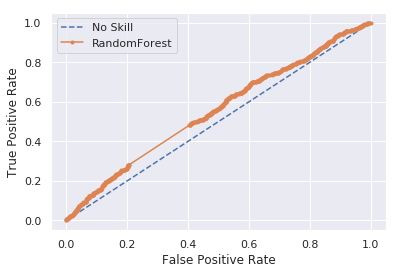

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

clf = RandomForestClassifier(n_estimators=300)
clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))
probs = clf.predict_proba(X_test_cv)
lr_probs = probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RandomForest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

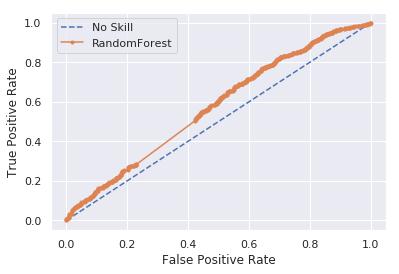

In [26]:
#This is just the code for getting an AUC plot. I could stick it into a function.
probs = clf.predict_proba(X_test_cv)
lr_probs = probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RandomForest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [27]:
df['tokenstr'].head()

0            &emailalert=no&email=adgrant@indiana.e...
1               ok, a summary of the weekend then.....
2               i have sewn a fender guitar onto my...
3                  live life its all we have!         
4           my colleagues&nbsp;bought me&nbsp;lunch...
Name: tokenstr, dtype: object

In [28]:
from sklearn.metrics import roc_auc_score
ns_auc = roc_auc_score(y_test, ns_probs)
ns_auc

0.5

In [188]:
#Best score of anything. F1=.724346
from sklearn.svm import SVC
clf = SVC(gamma = 'auto', C=1, kernel='poly', degree=3)
clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

Accuracy score:  0.5409836065573771
F1 score:  0.7021276595744682


Accuracy score:  0.5592686002522068
F1 score:  0.6964828484585323


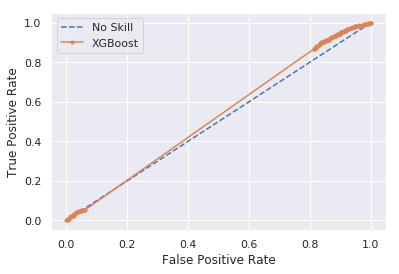

In [189]:
from xgboost import XGBClassifier
clf = XGBClassifier(num_boosting_rounds=500, eta=0.05)
clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))
probs = clf.predict_proba(X_test_cv)
lr_probs = probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [200]:
#Best score. .72599
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', C=0.08, solver='lbfgs')
# lr = LogisticRegression(penalty='elasticnet', C=0.2, solver='saga')

lr.fit(X_train_cv, y_train)
lr_bow_prediction = lr.predict(X_test_cv)

print (metrics.accuracy_score(y_test , lr_bow_prediction))
print (metrics.confusion_matrix(y_test , lr_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

0.5680958385876419
[[156 572]
 [113 745]]
F1 score:  0.6850574712643679
Precision score:  0.5656795747911921
Recall score:  0.8682983682983683


# Using tf-idf from gensim, not sklearn
Need Preet to look at this.

In [67]:
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

dataset = df['formatted']
dct = Dictionary(dataset)  # fit dictionary
corpus = [dct.doc2bow(line) for line in dataset]  # convert corpus to BoW format

gtfidf = TfidfModel(corpus)  
# gensim_x = gtfidf(X_train)

In [ ]:
# from gensim.models import TfidfModel
# test = TfidfModel(corpus)
# from gen
# vectors = [model[dictionary.doc2bow(doc)] for doc in X_train]
import gensim
corpus  = [doc for doc in X_train]
lexicon = gensim.corpora.Dictionary(corpus)
tfidf   = gensim.models.TfidfModel(dictionary=lexicon, normalize=True)
vectors = [tfidf[lexicon.doc2bow(doc)] for doc in corpus]

In [ ]:
X_test_g

In [ ]:
from gensim.sklearn_api import TfIdfTransformer
from gensim.corpora import Dictionary
X = df['formatted']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

dictionary = Dictionary(X_train)
model = TfIdfTransformer(dictionary)
train = [dictionary.doc2bow(text) for text in X_train]
test = [dictionary.doc2bow(text) for text in X_test]
X_train_g =  model.fit_transform(train)
X_test_g = model.fit_transform(test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf = clf.fit(X_train_g, y_train)
y_preds=clf.predict(X_test_g)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

In [98]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(penalty='l2', max_iter=500, C=0.8, solver='lbfgs')
lgb.fit(X_train_g, y_train)
lr_bow_prediction = lgb.predict(X_test_g)

print (metrics.confusion_matrix(y_test , lr_bow_prediction))
print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

NameError: name 'X_train_g' is not defined

# Using sklearn's tf-idf:

In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(use_idf=True, min_df=3, max_df=25, analyzer='word', smooth_idf=True,
                       norm = 'l2', ngram_range=[3,5], sublinear_tf=True)
# X=df['form_str']
X=df['tokenstr']
X_train, X_test, y_train, y_test = train_test_split(X,y)
tfid_train_matrix = tfid.fit_transform(X_train)
tfid_test_matrix = tfid.transform(X_test)

In [210]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=450, learning_rate=0.1, reg_alpha=0.2, reg_lambda=0)
lgb.fit(tfid_train_matrix, y_train)
lr_bow_prediction = lgb.predict(tfid_test_matrix)

print (metrics.confusion_matrix(y_test , lr_bow_prediction))
print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

[[150 557]
 [122 757]]
F1 score:  0.6903784769721842
Precision score:  0.576103500761035
Recall score:  0.8612059158134243


[[  0 707]
 [  0 879]]
F1 score:  0.713184584178499
Precision score:  0.5542244640605296
Recall score:  1.0


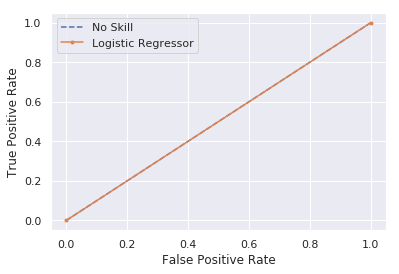

In [218]:
#Best score: .7266
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', max_iter=500, C=0.1, solver='liblinear', intercept_scaling=1.2)
lr.fit(tfid_train_matrix, y_train)
lr_bow_prediction = lr.predict(tfid_test_matrix)

print (metrics.confusion_matrix(y_test , lr_bow_prediction))
print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

probs = lr.predict_proba(tfid_test_matrix)
lr_probs = probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regressor')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

In [219]:
from sklearn.metrics import precision_recall_curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_preds), roc_curve(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

TypeError: must be real number, not tuple

In [142]:
#Best score .7266
from sklearn.naive_bayes import MultinomialNB, GaussianNB
clf = MultinomialNB(alpha=8.7)
# clf=GaussianNB(var_smoothing=1e-09)
clf = clf.fit(tfid_train_matrix.toarray(), y_train)
y_preds=clf.predict(tfid_test_matrix.toarray())
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

Accuracy score:  0.5542244640605296
F1 score:  0.713184584178499


In [220]:
from xgboost import XGBClassifier
clf = XGBClassifier(num_boosting_rounds=900, learning_rate=.25, min_samples_split=10)
clf.fit(tfid_train_matrix, y_train)
y_preds=clf.predict(tfid_test_matrix)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

Accuracy score:  0.575031525851198
F1 score:  0.6885397412199631


# Time to use Word2Vec

In [221]:
#Make tokenized versions of X_train
import nltk
X_train_tok = [nltk.word_tokenize(t) for t in X_train]
X_test_tok = [nltk.word_tokenize(t) for t in X_test]
from gensim.models import Word2Vec
w2vm = Word2Vec(X_train_tok, size=350, window=15, negative=2)
w2v = dict(zip(w2vm.wv.index2word, w2vm.wv.syn0))
w2vm.wv.index2entity[:15]

/home/drew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  import sys


['.',
 ',',
 'i',
 'the',
 'to',
 'and',
 'a',
 'of',
 'it',
 'that',
 'in',
 '!',
 'my',
 'is',
 'you']

In [222]:
def averaged_word2vec_vectorizer(corpus , model , num_features):
    vocabulary = set (model.wv.index2word)
    def average_word_vectors(words, model , vocabulary , num_features):
        feature_vector = np.zeros((num_features) , dtype = 'float64')
        nwords = 0
        for word in words : 
            if word in vocabulary:
                nwords += 1 
                feature_vector = np.add(feature_vector , model.wv[word])
        if nwords: 
            feature_vector = np.divide(feature_vector , nwords)
        return feature_vector
    
    features = [average_word_vectors(tokenized_sentence , model, vocabulary , num_features) 
                for tokenized_sentence in corpus]
    return np.array(features)

avg_wv_train_features = averaged_word2vec_vectorizer(corpus= X_train_tok , model = w2vm, num_features= 350)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus= X_test_tok , model = w2vm , num_features= 350)

In [223]:
w2vm.train(X_train_tok, total_examples=len(X_train_tok), epochs=10)

KeyboardInterrupt: 

In [224]:
lr = LogisticRegression(penalty='l1', max_iter=500, C=2, solver='liblinear')
lr.fit(avg_wv_train_features, y_train)
lr_bow_prediction = lr.predict(avg_wv_test_features)

print (metrics.accuracy_score(y_test , lr_bow_prediction))
print (metrics.confusion_matrix(y_test , lr_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

0.6185372005044136
[[316 391]
 [214 665]]
F1 score:  0.6873385012919897
Precision score:  0.6297348484848485
Recall score:  0.7565415244596132


In [231]:
#Best score so far: .71318
from sklearn.svm import SVC
clf = SVC(gamma = 'auto', C=0.1, kernel='poly', degree=2)
clf.fit(avg_wv_train_features, y_train)
y_preds=clf.predict(avg_wv_test_features)
print (metrics.confusion_matrix(y_test , y_preds))
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

[[  0 707]
 [  0 879]]
Accuracy score:  0.5542244640605296
F1 score:  0.713184584178499


In [232]:
from xgboost import XGBClassifier
clf = XGBClassifier(num_boosting_rounds=500, eta=0.2)
clf.fit(avg_wv_train_features, y_train)
y_preds=clf.predict(avg_wv_test_features)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))
#Best score? 0.679

Accuracy score:  0.6242118537200504
F1 score:  0.6750272628135224


In [96]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=400, reg_alpha=0.2, reg_lambda=0.4)
lgb.fit(avg_wv_train_features, y_train)
lr_bow_prediction = lgb.predict(avg_wv_test_features)

print (metrics.confusion_matrix(y_test, lr_bow_prediction))
print("F1 score: ", metrics.f1_score(y_test, lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test, lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test, lr_bow_prediction))

[[401 323]
 [252 610]]
F1 score:  0.67966573816156
Precision score:  0.6538049303322615
Recall score:  0.7076566125290024


# FastAI's ULMFiT

In [ ]:
# train_df = pd.DataFrame(avg_wv_train_features)
train_df = pd.DataFrame(tfid_train_matrix)
train_df['gender'] = y_train
valid_df = pd.DataFrame(tfid_test_matrix)
valid_df['gender'] = y_test

from fastai.text import * 
data_lm = TextClasDataBunch.from_df(path='.',train_df = train_df, valid_df=valid_df, 
                                    label_cols='gender')

In [ ]:
# df.head()

In [ ]:
learn = text_classifier_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained=False)

In [ ]:
data_lm.show_batch()

In [ ]:
learn.fit_one_cycle(3, 3e-2)

In [ ]:
# pd.Series(pred_val).value_counts()

In [ ]:
learn.config()

In [ ]:
pred_val = learn.get_preds(DatasetType.Valid, ordered=True)
pred_val_l = pred_val[0].argmax(1)
print(classification_report(pred_val[1], pred_val_l))

In [ ]:
# df['tokenstr']
#I need to take out the formatting if I'm going to use deep learning.

In [ ]:
clf = text_classifier_learner(data_lm, AWD_LSTM, drop_mult=0.25, pretrained=False)
# pred_val = clf.get_preds(DatasetType.Valid, ordered=True)

In [ ]:
# clf.recorder.plot()
clf.fit(5, 7e-2)

In [ ]:
pred_val = clf.get_preds(DatasetType.Valid, ordered=True)
pred_val_l = pred_val[0].argmax(1)
print(classification_report(pred_val[1], pred_val_l))

# Now trying a LSTM model.

In [ ]:
from sklearn.preprocessing import LabelEncoder
import keras
le = LabelEncoder()

y_tr = le.fit_transform(y_train)
y_dnn_train = keras.utils.to_categorical(y_tr , num_classes= 2)

y_ts = le.fit_transform(y_test)
y_dnn_test = keras.utils.to_categorical(y_ts , num_classes= 2)

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense , Flatten
from sklearn.preprocessing import LabelEncoder
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam , SGD 
from keras import regularizers, Sequential

model = Sequential()
# Hidden Layers
model.add(Dense(64, activation='tanh', input_shape=(8785,), kernel_regularizer = regularizers.l2(0.05) ))
model.add(Dropout(0.3))
model.add(Dense(64 , activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(64 , activation = 'tanh'))
model.add(BatchNormalization())
# Output Layer
model.add(Dense(2, activation='softmax'))
model.summary()

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss = 'binary_crossentropy' , optimizer= 'adam' , metrics = ['acc',f1_m,precision_m, recall_m])

In [ ]:
model.fit(tfid_train_matrix, y_dnn_train, batch_size=500, epochs=200, verbose=1, 
          validation_data=(tfid_test_matrix, y_dnn_test))